#Testing some of Elhers indicators

## Instantaneous Trend

In [16]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [17]:
import pandas as pd
import numpy as np

from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [18]:
# Load data, specifically AAPL minute OHLC data from 2015-07-14
data = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
time = data.index           # Useful for the plots.
price = data.CLOSE.as_matrix() #(0.5 * (data.HIGH + data.LOW)).as_matrix() 

In [19]:
# Define an SMA lag and the equivalent EMA alpha.
SMA_lag = 10
alpha = 2.0 / (SMA_lag + 1)       #0.07

a_ = (alpha / 2.0) ** 2
b_ = (1 - alpha)

IT = np.zeros(len(price))
LT = np.zeros(len(price))     # Instantaneous Trend Lead Trigger

# Make the first indicator values equal to prices for faster convergence.
IT[:2] = price[:2]
LT[:2] = price[:2]

for n in range(2, len(price)):
    IT[n] = (alpha - a_) * price[n] + (2 * a_) * price[n-1] - (alpha - 3 * a_) * price[n-2] \
            + (2 * b_) * IT[n-1] - (b_ ** 2) * IT[n-2]
    LT[n] = 2 * IT[n] - IT[n-2]

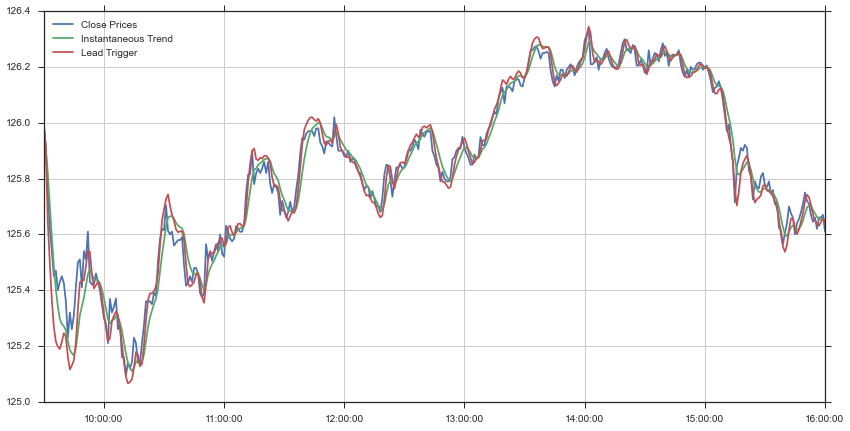

In [20]:
plt.plot(time, data.CLOSE.as_matrix(), label='Close Prices')
plt.plot(time, IT, label='Instantaneous Trend')
plt.plot(time, LT, label='Lead Trigger')
plt.legend(loc='upper left')
plt.grid()

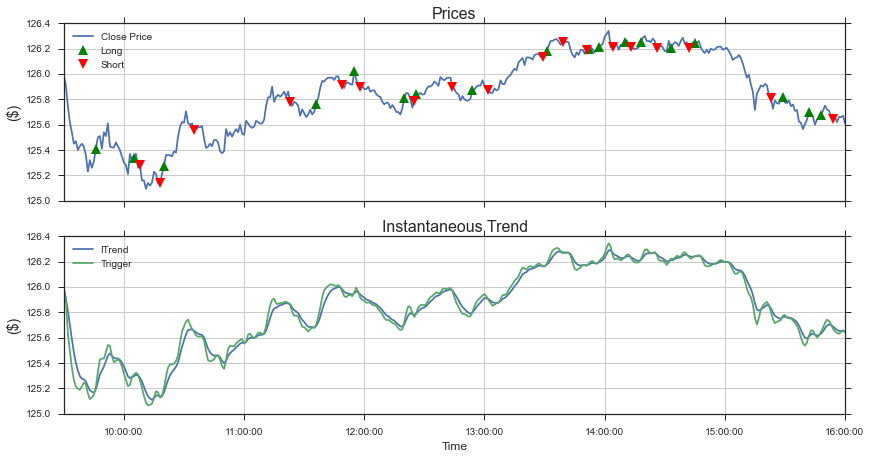

In [21]:
df = pd.DataFrame(np.transpose(np.vstack((data.CLOSE, IT, LT))), index=data.index,
                  columns=['Price', 'Trend', 'Trigger'])

tol = 0.0025 # Tolerance

# Generate a boolean array to use as index for the events.
long_signal = (df.Trend.shift() > df.Trigger.shift() + tol) & (df.Trend < df.Trigger - tol)
short_signal = (df.Trend.shift() < df.Trigger.shift() - tol) & (df.Trend > df.Trigger + tol)

# This plot will contains two subplos sharing the x axis.
fig, ax = plt.subplots(2, sharex=True)

# The first subplot is the close price and the orders.
ax[0].set_title('Prices', fontsize=16)
ax[0].plot(time, df.Price, label='Close Price')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].set_ylabel('($)', fontsize=14)
ax[0].legend(loc='upper left')
ax[0].grid()

# The second subplot are the indicator and the trigger.
ax[1].set_title('Instantaneous Trend', fontsize=16)
ax[1].plot(time, df.Trend, label='ITrend')
ax[1].plot(time, df.Trigger, label='Trigger')
ax[1].set_ylabel('($)', fontsize=14)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].legend(loc='upper left')
ax[1].grid()

Seems the Instantaneous Trend - Lead Trigger schema only works fine in strong trend situation. If not, there are many false signals.

# SuperSmoother

In [22]:
# Two-pole modified Butterworth filter 
period = 15    # Critial period
a = np.exp(-1.414 * pi / period)
b = 2 * a * np.cos(1.414 * 1.25 * pi / period)
c2 = b
c3 = -(a ** 2)
c1 = 1 - c2 - c3

two_pole_BFilter = np.zeros(len(price))
two_pole_BFilter[:2] = price[:2]

for n in range(2, len(price)):
    two_pole_BFilter[n] = c1 * price[n] + c2 * two_pole_BFilter[n-1] + \
                          c3 * two_pole_BFilter[n-2] # The book has an error here!

# Three-pole modified Butterworth filter 
a = np.exp(-pi / period)
b = 2 * a * np.cos(1.738 * pi / period)
c = a ** 2
d2 = b + c
d3 = -(c + b * c) 
d4 = c ** 2
d1 = 1 - d2 - d3 - d4

three_pole_BFilter = np.zeros(len(price))
three_pole_BFilter[:3] = price[:3]

for n in range(3, len(price)):
    three_pole_BFilter[n] = d1 * price[n] + d2 * three_pole_BFilter[n-1] + d3 * three_pole_BFilter[n-2] + \
                            d4 * three_pole_BFilter[n-3] # And yet the book has another error here!

# SuperSmoother
a = np.exp(-1.414 * pi / period)
b = 2 * a * np.cos(1.414 * pi / period)
c2 = b
c3 = -(a ** 2)
c1 = 1 - c2 - c3

SS = np.zeros(len(price))
SS[:2] = price[:2]

for n in range(2, len(price)):
    SS[n] = c1 / 2 * (price[n] + price[n-1]) + c2 * SS[n-1] + c3 * SS[n-2] 

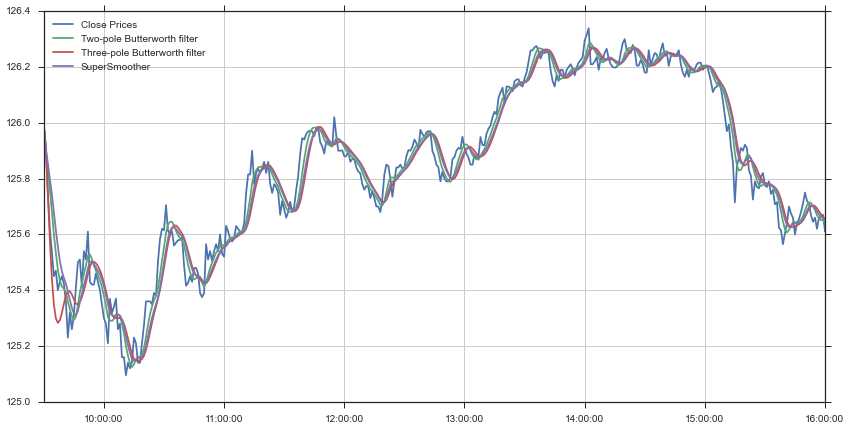

In [23]:
# Plotting
plt.plot(time, data.CLOSE, label='Close Prices')
plt.plot(time, two_pole_BFilter, label='Two-pole Butterworth filter')
plt.plot(time, three_pole_BFilter, label='Three-pole Butterworth filter')
plt.plot(time, SS, label='SuperSmoother')
plt.legend(loc='upper left')
plt.grid()

##Decycler

In [24]:
cutoff = 15 # cut of frequency for the high pass filter

decycle = np.zeros(len(price))
decycle[:1] = price[:1]

alpha = (np.cos(2 * pi / cutoff) + np.sin(2 * pi / cutoff) - 1) / np.cos(2 * pi / cutoff)

for n in range(1, len(price)):
    decycle[n] = (alpha / 2) * (price[n] + price[n-1]) + (1 - alpha) * decycle[n-1]

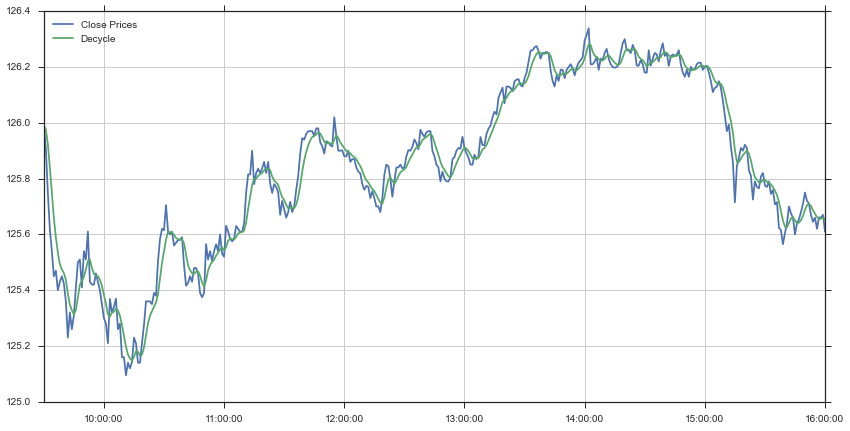

In [25]:
# Plotting
plt.plot(time, data.CLOSE.as_matrix(), label='Close Prices')
plt.plot(time, decycle, label='Decycle')
plt.legend(loc='upper left')
plt.grid()

## Applying Inverse Fisher to the trends

In [26]:
def fisher_inverse(df, norm_window):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / (pd.rolling_max(df, norm_window) - \
                                                        pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Smoothing df_value by applying EMA with alpha 0.5.
    # df_value = 0.5 * df_value + 0.5 * df_value.shift()
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    df_inverse_fisher = (np.exp(2*df_value) - 1) / (np.exp(2*df_value) + 1)
    return df_inverse_fisher #0.5 * df_inverse_fisher + 0.5 * df_inverse_fisher.shift()

In [27]:
df = pd.DataFrame(np.transpose(np.vstack((data.CLOSE, decycle, SS, IT, two_pole_BFilter))), index=data.index,
                  columns=['Price', 'Decycle', 'SS', 'IT', 'TPBF'])
norm_window = 20
df['IFD'] = fisher_inverse(df.Decycle, norm_window)        # Inverse Fisher Decycle
df['IFSS'] = fisher_inverse(df.SS, norm_window)            # Inverse Fisher SuperSmoother
df['IFIT'] = fisher_inverse(df.IT, norm_window)            # Inverse Fisher Instantaneous Trend
df['IFTPBF'] = fisher_inverse(df.TPBF, norm_window)        # Inverse Fisher Two-pole modified Butterworth filter 

In [29]:
def trigger_idx(pd_series, threshold, tol):
    cond_1 = (pd_series.shift() < threshold) & (pd_series > threshold + tol)
    cond_2 = (pd_series.shift() > threshold) & (pd_series < threshold - tol)

    cond_3 = (pd_series.shift() < -threshold) & (pd_series > -threshold + tol)
    cond_4 = (pd_series.shift() > -threshold) & (pd_series < -threshold - tol)
    return list([cond_1, cond_2, cond_3, cond_4])

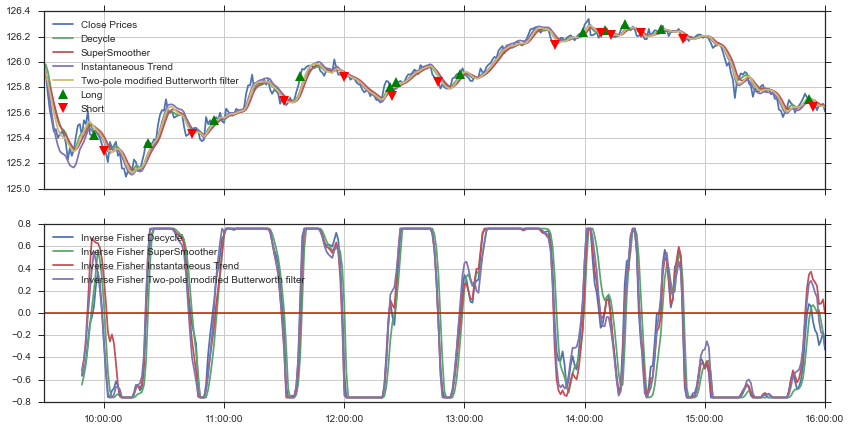

In [30]:
f, ax = plt.subplots(2, sharex=True)

threshold = 0.0025

trigger = trigger_idx(df.IFD, threshold, tol)

long_signal = trigger[2]
short_signal = trigger[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time, df.Decycle, label='Decycle')
ax[0].plot(time, df.SS, label='SuperSmoother')
ax[0].plot(time, df.IT, label='Instantaneous Trend')
ax[0].plot(time, df.TPBF, label='Two-pole modified Butterworth filter')

ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(time, df.IFD, label='Inverse Fisher Decycle')
ax[1].plot(time, df.IFSS, label='Inverse Fisher SuperSmoother')
ax[1].plot(time, df.IFIT, label='Inverse Fisher Instantaneous Trend')
ax[1].plot(time, df.IFTPBF, label='Inverse Fisher Two-pole modified Butterworth filter')
ax[1].legend(loc='upper left')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].grid()
plt.show()